In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.lab import Particles

from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4

def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# Start with SMBH
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

In [2]:
def relative_orbital_velocity(distance, mass=SMBH.mass):
    return (constants.G*mass/distance).sqrt()

def plot(body):
    scatter(body.x.value_in(units.pc), body.y.value_in(units.pc), s=20, alpha=0.5)
    #scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=80, c='r')
    pyplot.xlim(-r, r)
    pyplot.ylim(-r, r)
#     pyplot.colorbar()
#     pyplot.show()

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

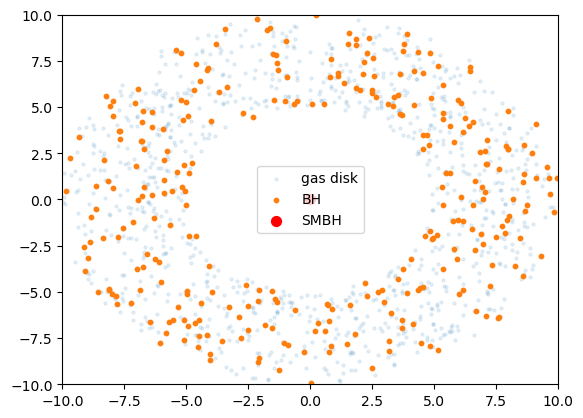

In [3]:
n_BHs = 300 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of our BHs surrounding the SMBH

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.5
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, 2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.5
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
    gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name

# The initial distribution of our objects
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
pyplot.xlim(-r, r)
pyplot.ylim(-r, r)
pyplot.legend(loc="best")
pyplot.show()

In [4]:
# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Actually merger occurred:")
    print("Two BHs (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            print("The merged two BHs:")
            print(colliding_BHs)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G = constants.G):
    """
    returns the binaries in a particleset. binaries are selected according to a hardness criterion [hardness=10]
    This function returns the binaries as a list of i,j particles. Triple detection is not done.
    
    >>> from amuse import datamodel
    >>> m = [1,1,1] | units.MSun
    >>> x = [-1,1,0] | units.AU
    >>> y = [0,0,1000] | units.AU
    >>> z = [0,0,0] | units.AU
    >>> vx = [0,0,0] | units.kms
    >>> vy = [1.,-1.,0] | units.kms
    >>> vz = [0,0,0] | units.kms
    >>> particles = datamodel.create_particle_set( mass=m,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz )
    >>> binaries = particles.get_binaries()
    >>> print len(binaries)
    1
    
    """
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
#     particles.dist=dist(particles)
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                binaries.append(binary)
            j+=1  

    return binaries

## Nbody simulation

## Bridge Nbody with gas disk

In [5]:
from amuse.community.huayno.interface import Huayno
from amuse.community.fi.interface import Fi

bodies = Particles(0)
bodies.add_particles(SMBH)
bodies.add_particles(BHdisk)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

Nbody = SMBH+BHdisk

gravityA = ph4(converter2, number_of_workers=32)
gravityA.particles.add_particles(Nbody)
channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter2, mode="openmp", workers=32)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 1e-3*Pinner2 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 10 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

bodies.add_particles(gasdisk)
gasdisk = bodies[bodies.name=="gas disk"]

hydro.particles.add_particles(gasdisk)
# hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
# channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
# channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

In [6]:
from amuse.couple import bridge
from amuse.ext.composition_methods import *
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5
# SMBH.radius *= collision_radius_multiplication_factor
# BHdisk.radius *= collision_radius_multiplication_factor
Nbody.radius *= collision_radius_multiplication_factor

gravhydro.timestep = 1e-2*Pinner2
print(1e-2*Pinner2.in_(units.yr))

[5138.32874606] 31556925.993600003 * s


4 Binary found at t = [0.154149862382] Myr
Binary 1 is BH169 BH42 with hardness = 2.35721430396
Binary 2 is BH124 BH40 with hardness = 1.21497351751
Binary 3 is BH276 BH62 with hardness = 0.592002002436
Binary 4 is BH192 BH181 with hardness = 0.940208941312


4 Binary found at t = [0.308299724764] Myr
Binary 1 is BH124 BH40 with hardness = 0.572903878074
Binary 2 is BH99 BH40 with hardness = 0.614794923245
Binary 3 is BH169 BH42 with hardness = 2.37361934789
Binary 4 is BH192 BH181 with hardness = 0.936677656764


3 Binary found at t = [0.462449587145] Myr
Binary 1 is BH40 BH124 with hardness = 0.990572392918
Binary 2 is BH192 BH181 with hardness = 0.934088455975
Binary 3 is BH169 BH42 with hardness = 2.3253380083


4 Binary found at t = [0.616599449527] Myr
Binary 1 is BH192 BH181 with hardness = 0.933833585111
Binary 2 is BH122 BH254 with hardness = 0.676530783398
Binary 3 is BH40 BH124 with hardness = 1.09052264733
Binary 4 is BH169 BH42 with hardness = 2.3133215324


Evolved to t =

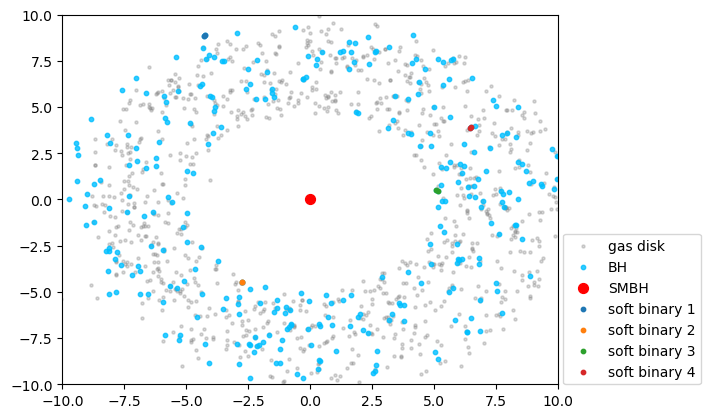




3 Binary found at t = [0.770749311909] Myr
Binary 1 is BH192 BH181 with hardness = 0.937558108206
Binary 2 is BH124 BH40 with hardness = 1.05941417047
Binary 3 is BH33 BH42 with hardness = 2.5089572927


3 Binary found at t = [0.924899174291] Myr
Binary 1 is BH192 BH181 with hardness = 0.945996593026
Binary 2 is BH33 BH42 with hardness = 2.51020136796
Binary 3 is BH124 BH40 with hardness = 0.910303085488


3 Binary found at t = [1.07904903667] Myr
Binary 1 is BH42 BH33 with hardness = 2.36073705312
Binary 2 is BH192 BH181 with hardness = 0.950001246483
Binary 3 is BH40 BH124 with hardness = 0.9144002395


Evolved to t = [1.07904903667] Myr 
BH number = 300 
Map of all particles:


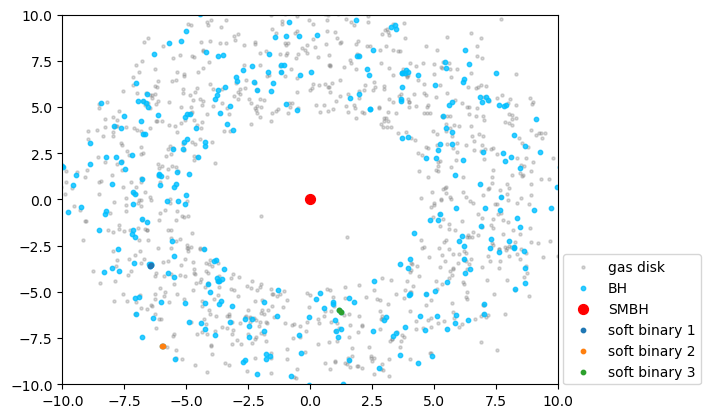




6 Binary found at t = [1.23319889905] Myr
Binary 1 is BH263 BH91 with hardness = 0.677927832362
Binary 2 is BH33 BH42 with hardness = 2.35505470032
Binary 3 is BH42 BH169 with hardness = 0.633714749059
Binary 4 is BH192 BH181 with hardness = 0.950040214792
Binary 5 is BH122 BH211 with hardness = 0.552025398884
Binary 6 is BH40 BH124 with hardness = 0.994475229826


3 Binary found at t = [1.38734876144] Myr
Binary 1 is BH40 BH124 with hardness = 0.982298236025
Binary 2 is BH192 BH181 with hardness = 0.94675526498
Binary 3 is BH33 BH42 with hardness = 3.25239602761


3 Binary found at t = [1.54149862382] Myr
Binary 1 is BH40 BH124 with hardness = 1.02103016264
Binary 2 is BH33 BH42 with hardness = 3.22601018525
Binary 3 is BH192 BH181 with hardness = 0.935481121262


3 Binary found at t = [1.6956484862] Myr
Binary 1 is BH40 BH124 with hardness = 1.00486002444
Binary 2 is BH33 BH42 with hardness = 3.23510513112
Binary 3 is BH192 BH181 with hardness = 0.722981134416


Evolved to t = [1.

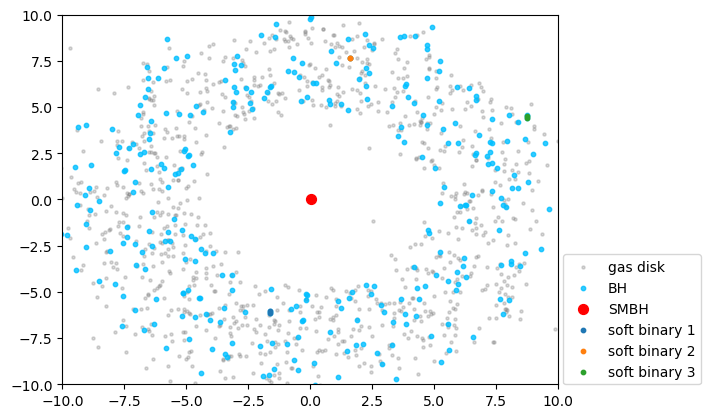




3 Binary found at t = [1.84979834858] Myr
Binary 1 is BH33 BH42 with hardness = 3.33317423194
Binary 2 is BH181 BH192 with hardness = 0.682206075803
Binary 3 is BH40 BH124 with hardness = 0.985150248507


3 Binary found at t = [2.00394821096] Myr
Binary 1 is BH33 BH42 with hardness = 3.37009442815
Binary 2 is BH181 BH192 with hardness = 0.700839362123
Binary 3 is BH40 BH124 with hardness = 0.992492398272


3 Binary found at t = [2.15809807334] Myr
Binary 1 is BH192 BH181 with hardness = 0.698521216141
Binary 2 is BH40 BH124 with hardness = 0.996170443353
Binary 3 is BH33 BH42 with hardness = 3.29074894905


Evolved to t = [2.15809807334] Myr 
BH number = 300 
Map of all particles:


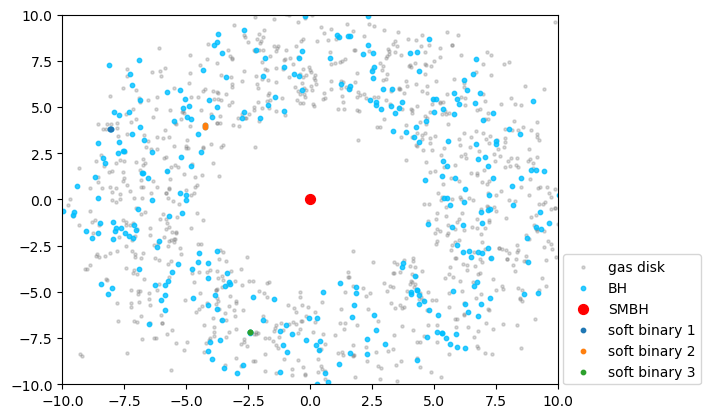




3 Binary found at t = [2.31224793573] Myr
Binary 1 is BH181 BH192 with hardness = 0.695156490151
Binary 2 is BH124 BH40 with hardness = 1.07095824968
Binary 3 is BH33 BH42 with hardness = 1.5515842807


3 Binary found at t = [2.46639779811] Myr
Binary 1 is BH181 BH192 with hardness = 0.69567465598
Binary 2 is BH124 BH40 with hardness = 1.1194867596
Binary 3 is BH42 BH33 with hardness = 1.54597435509


3 Binary found at t = [2.62054766049] Myr
Binary 1 is BH181 BH192 with hardness = 0.698173152905
Binary 2 is BH42 BH33 with hardness = 1.55631512968
Binary 3 is BH124 BH40 with hardness = 1.11069245762


Evolved to t = [2.62054766049] Myr 
BH number = 300 
Map of all particles:


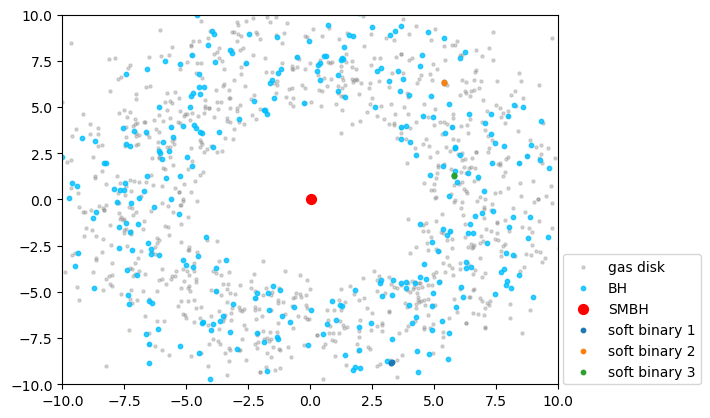

In [ ]:
from amuse.ext.composition_methods import *
from amuse.ext.orbital_elements import orbital_elements_from_binary

def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies,
                         t_end):

    gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()
    model_time = 0 | units.Myr
    dt = 0.3*Pinner2
    x=1
    while model_time < t_end:    

#         orbit_planet = orbital_elements_from_binary(bodies[:2], G=constants.G)
#         orbit_moon = orbital_elements_from_binary(bodies[1:3], G=constants.G)
#         print("Planet:", "ae=", orbit_planet[2].in_(units.AU), orbit_planet[3])
#         print("Moon:", "ae=", orbit_moon[2].in_(units.AU), orbit_moon[3])
        
#         dE_gravity = gravity_initial_total_energy/(gravity.get_total_energy()+hydro.get_total_energy())
#         print("Time:", model_time.in_(units.day), \
#               "dE=", dE_gravity)#, dE_hydro

        if model_time.value_in(units.yr)>(x*Pinner2.value_in(units.yr)):
            x+=1
            print("Evolved to t =", model_time.in_(units.Myr),
                  "\nBH number =", len(BHdisk),
                 "\nMap of all particles:")

            scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
            scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='deepskyblue', label='BH')
            scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
            
            b = get_binaries(Nbody)
            if(len(b)>0):
                for i in range(len(b)):
                    if b[i].hardness[0]<10:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                   [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                   s=10, alpha=1, label='soft binary '+str(i+1))
                    else:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                   [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                   s=10, alpha=1, label='hard binary '+str(i+1))  
                        
            pyplot.xlim(-r, r)
            pyplot.ylim(-r, r)
            pyplot.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
            pyplot.show()
            print("\n\n")
        
        model_time += dt
        
#         BHdisk.collision_radius = BHdisk.radius * collision_radius_multiplication_factor
#         channel["from_BHs"].copy()
        gravhydro.evolve_model(model_time)
        resolve_collision(stopping_condition, gravityA, Nbody)
        
        channel["to_BHs"].copy()
        channel["to_gasdisk"].copy()
#         channel["to_smbh"].copy()
        
        b = get_binaries(Nbody)
        if(len(b)>0):
            print(len(b), "Binary found at t =", model_time.in_(units.Myr))
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name[0], b[i].name[1], "with hardness =", b[i].hardness[0])
                if b[i].hardness[0]>=10:
                    print("Here we have a hard binary!!!")
                    break
            print("\n")

        
#         print("S=", bodies[:3])
#         print("g=", gravity.particles)
#         print(gravity.particles.y.in_(units.pc), moon.y.in_(units.pc))

    gravityA.stop()
    hydro.stop()

t_end = 1000*Pinner2
gravity_hydro_bridge(gravityA, hydro, gravhydro, 
                     bodies, t_end)

# scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
# scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
# scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
# pyplot.xlim(-r, r)
# pyplot.ylim(-r, r)
# pyplot.legend(loc="best")
# pyplot.show()

In [ ]:
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
pyplot.xlim(-r, r)
pyplot.ylim(-r, r)
pyplot.legend(loc="best")
pyplot.show()

In [ ]:
# gravhydro.evolve_model(12.035 | units.Myr)

In [ ]:
b = get_binaries(Nbody, hardness=1)
print(len(b))